In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import VGG19
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, Dense, Input, BatchNormalization, AveragePooling2D
)

In [2]:
data_link = '/kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset'

In [3]:
def get_data(data_link):
    X = []
    y = []
    
    for dir in os.listdir(data_link):
        dir_path = os.path.join(data_link, dir)
        print(f"{dir} processed")
        
        # Skip if not a directory
        if not os.path.isdir(dir_path):
            continue
            
        for image_name in os.listdir(dir_path):
            image_path = os.path.join(dir_path, image_name)
            try:
                with Image.open(image_path) as img:
                    image_rgb = img.convert("RGB")
                    image_resized = image_rgb.resize((200, 200))
                    X.append(np.array(image_resized))
                    y.append(dir)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
    
    return np.array(X), np.array(y)

X, y = get_data(data_link)

Zain processed
Zah processed
Meem processed
Seen processed
Teh processed
Lam processed
Dad processed
Teh_Marbuta processed
Reh processed
Sad processed
Dal processed
Sheen processed
Hah processed
Beh processed
Tah processed
Alef processed
Waw processed
Qaf processed
Al processed
Ghain processed
Heh processed
Ain processed
Kaf processed
Thal processed
Feh processed
Khah processed
Yeh processed
Error processing /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Yeh/Yeh_61.jpg: image file is truncated (7 bytes not processed)
Jeem processed
Theh processed
Noon processed
Laa processed


In [4]:
X.shape

(7855, 200, 200, 3)

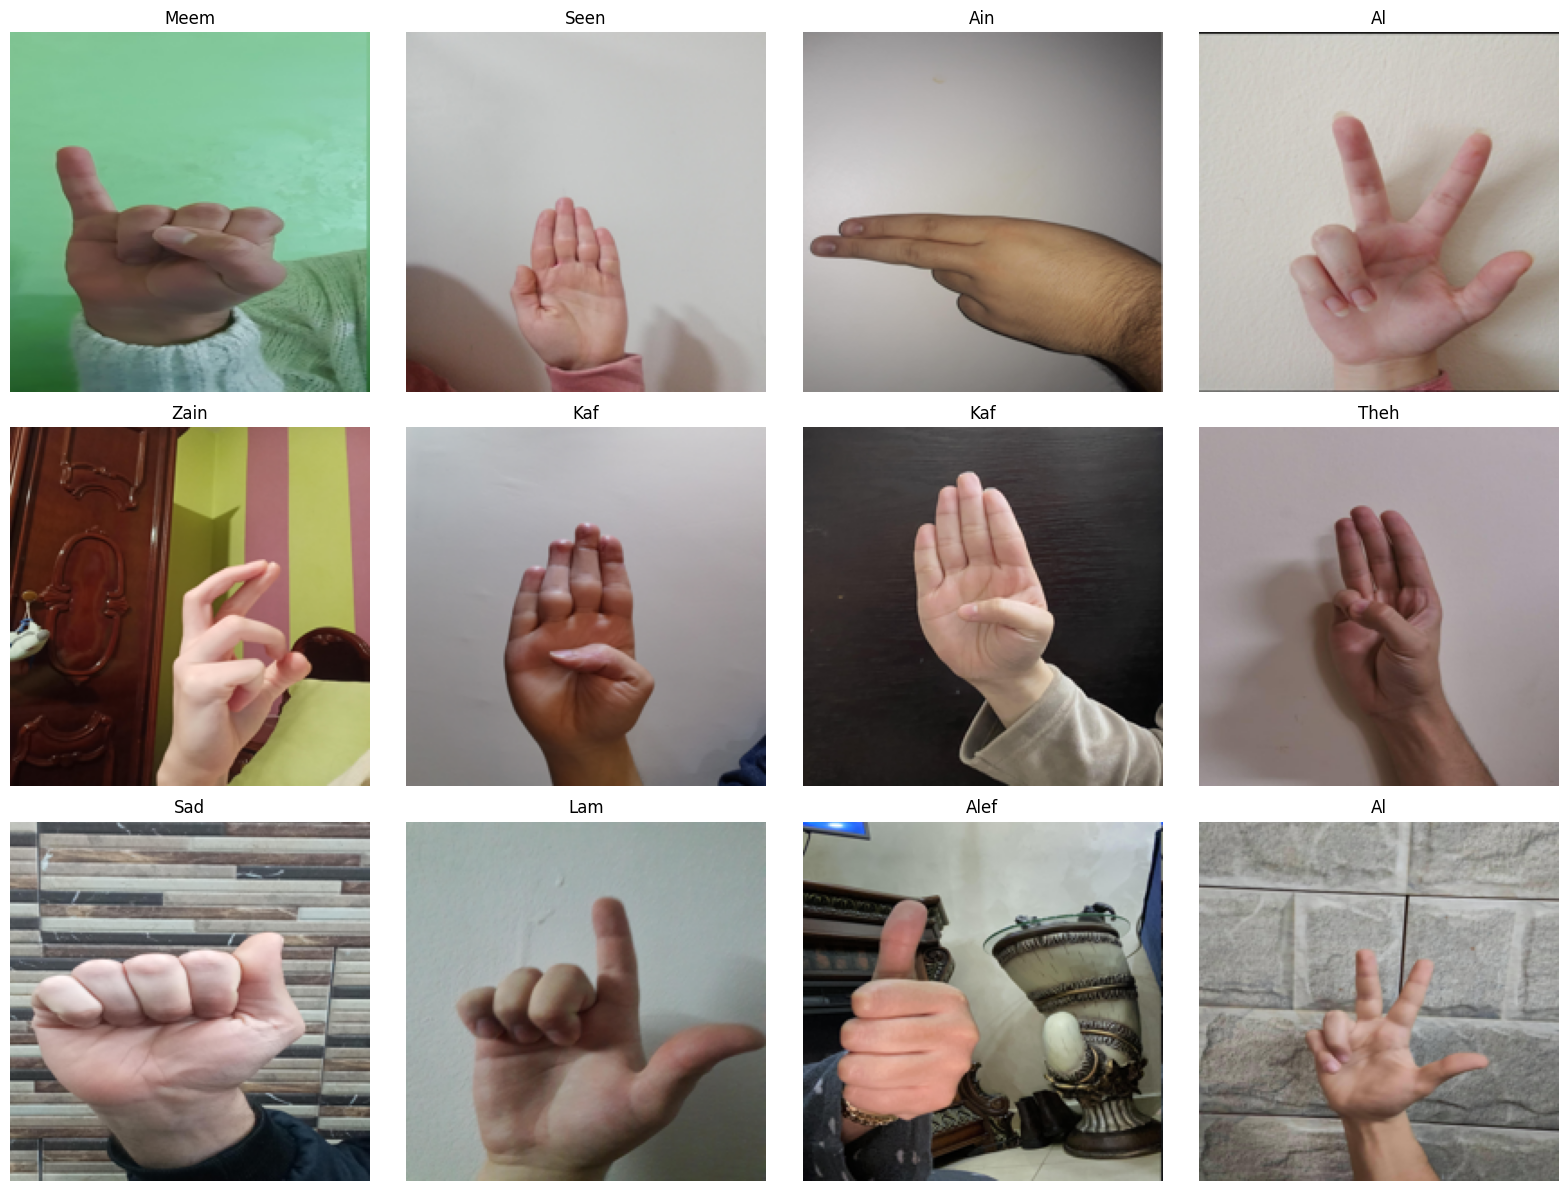

In [5]:
random_indices = random.sample(range(len(X)), 12)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

axes = axes.flatten()

for i, idx in enumerate(random_indices):
    axes[i].imshow(X[idx])
    axes[i].set_title(y[idx])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
np_X = np.array(X)
X_ = np_X.astype('float32')/255.0

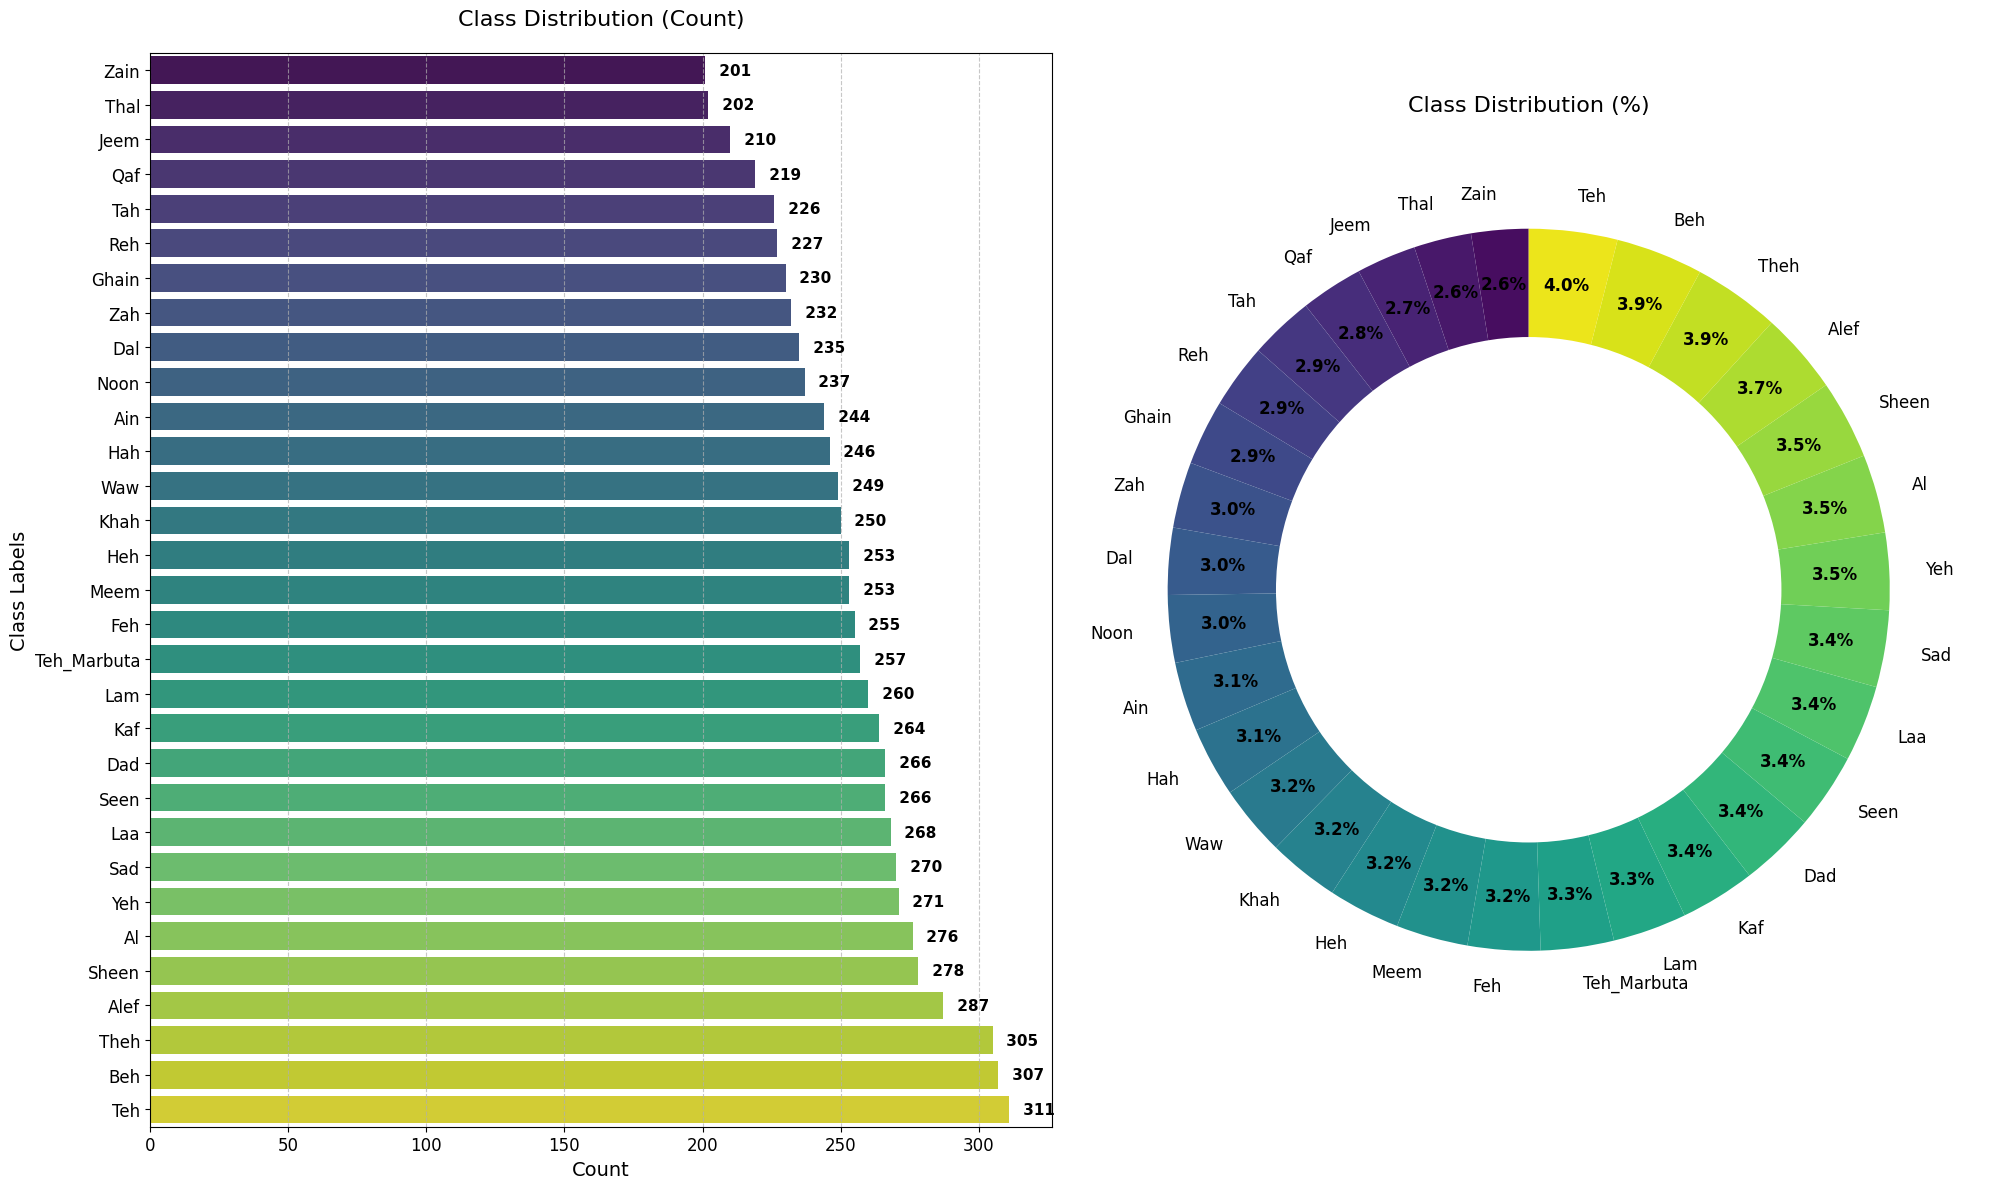

In [7]:
unique_classes, class_counts = np.unique(y, return_counts=True)

sort_idx = np.argsort(class_counts)
sorted_classes = unique_classes[sort_idx]
sorted_counts = class_counts[sort_idx]

plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
ax = sns.barplot(x=sorted_counts, y=sorted_classes, palette='viridis', orient='h')
plt.title('Class Distribution (Count)', fontsize=16, pad=20)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Class Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, count in enumerate(sorted_counts):
    plt.text(count + max(sorted_counts)*0.01, i, f' {count:,}', 
             va='center', fontsize=11, color='black', fontweight='bold')

plt.subplot(1, 2, 2)
wedges, texts, autotexts = plt.pie(sorted_counts, labels=sorted_classes, autopct='%1.1f%%', startangle=90,
                                  colors=sns.color_palette('viridis', n_colors=len(sorted_classes)),
                                  pctdistance=0.85, textprops={'fontsize': 12})

for autotext in autotexts:
    autotext.set_fontweight('bold')

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)
plt.title('Class Distribution (%)', fontsize=16, pad=20)

plt.tight_layout()
plt.show()

In [8]:
le = LabelEncoder()
le.fit(y)
y_ = le.transform(y)

num_classes = len(set(y_))

print(f"number of classes: {num_classes}")

number of classes: 31


In [9]:
X_temp, X_test, y_temp, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

In [10]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 5027 samples
Validation set: 1257 samples
Test set: 1571 samples


In [11]:
base_model = VGG19(weights='imagenet',include_top=False , input_shape=(200,200,3))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-4:]:
    layer.trainable = True

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 6, 6, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 31)                  │           7,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,426,335 (77.92 MB)

 Trainable params: 7,481,375 (28.54 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

In [12]:
with tf.device('/GPU:0'):
  history = model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      batch_size=32,
      epochs=100
  )

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 34s 144ms/step - accuracy: 0.0372 - loss: 3.5362 - val_accuracy: 0.0573 - val_loss: 3.3771
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.0647 - loss: 3.3789 - val_accuracy: 0.1559 - val_loss: 3.0963
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.1278 - loss: 3.0941 - val_accuracy: 0.2975 - val_loss: 2.6368
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.2199 - loss: 2.7023 - val_accuracy: 0.4129 - val_loss: 2.1709
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.3076 - loss: 2.3520 - val_accuracy: 0.4845 - val_loss: 1.8299
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.3958 - loss: 2.0076 - val_accuracy: 0.5720 - val_loss: 1.5173
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.4554 - loss: 1.7519 - val_accuracy: 0.6269 - val_loss: 1.3388
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.5126 - loss: 

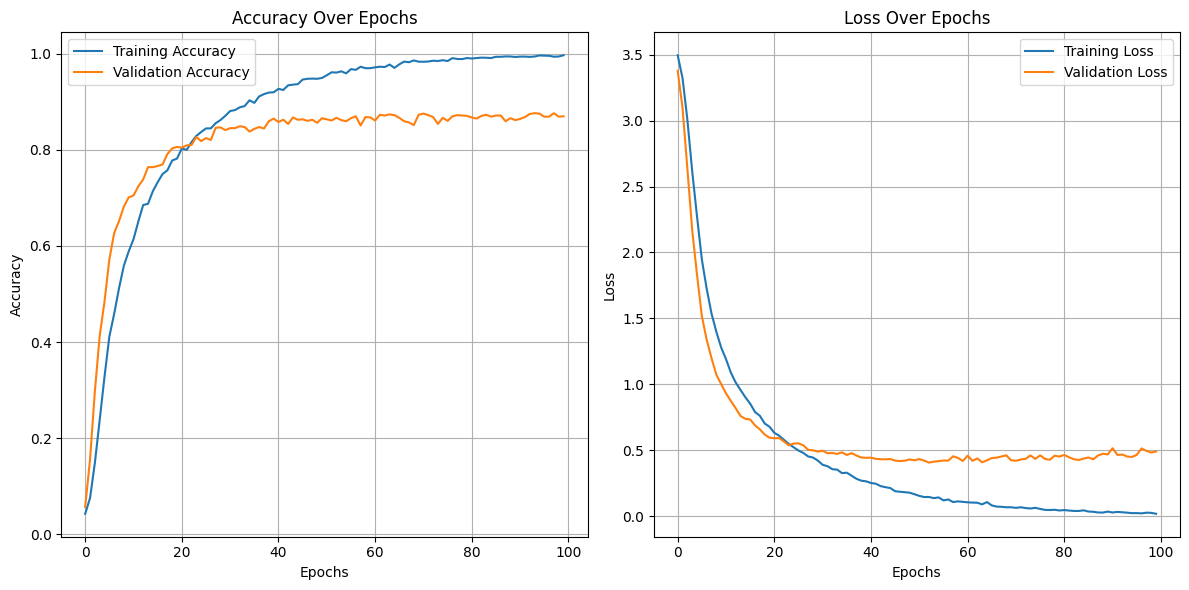

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
with tf.device('/GPU:0'):
  loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8922 - loss: 0.4697
Test Loss: 0.5151
Test Accuracy: 88.10%


In [15]:
with tf.device('/GPU:0'):
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)

y_test_decoded = le.inverse_transform(y_test)
y_pred_classes_decoded = le.inverse_transform(y_pred_classes)

report_dict = classification_report(y_test_decoded, y_pred_classes_decoded, output_dict=True)

report_df = pd.DataFrame(report_dict).transpose()

report_df

50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step


,precision,recall,f1-score,support
Ain,0.901961,0.938776,0.920000,49.000000
Al,0.980769,0.927273,0.953271,55.000000
Alef,0.932203,0.964912,0.948276,57.000000
Beh,0.875000,0.903226,0.888889,62.000000
Dad,0.944444,0.962264,0.953271,53.000000
Dal,0.727273,0.851064,0.784314,47.000000
Feh,0.796296,0.843137,0.819048,51.000000
Ghain,0.913043,0.913043,0.913043,46.000000
Hah,0.820000,0.836735,0.828283,49.000000
Heh,0.811321,0.843137,0.826923,51.000000


In [16]:
report_df.to_csv('arabic_sign_lang.csv')

<Figure size 800x600 with 0 Axes>

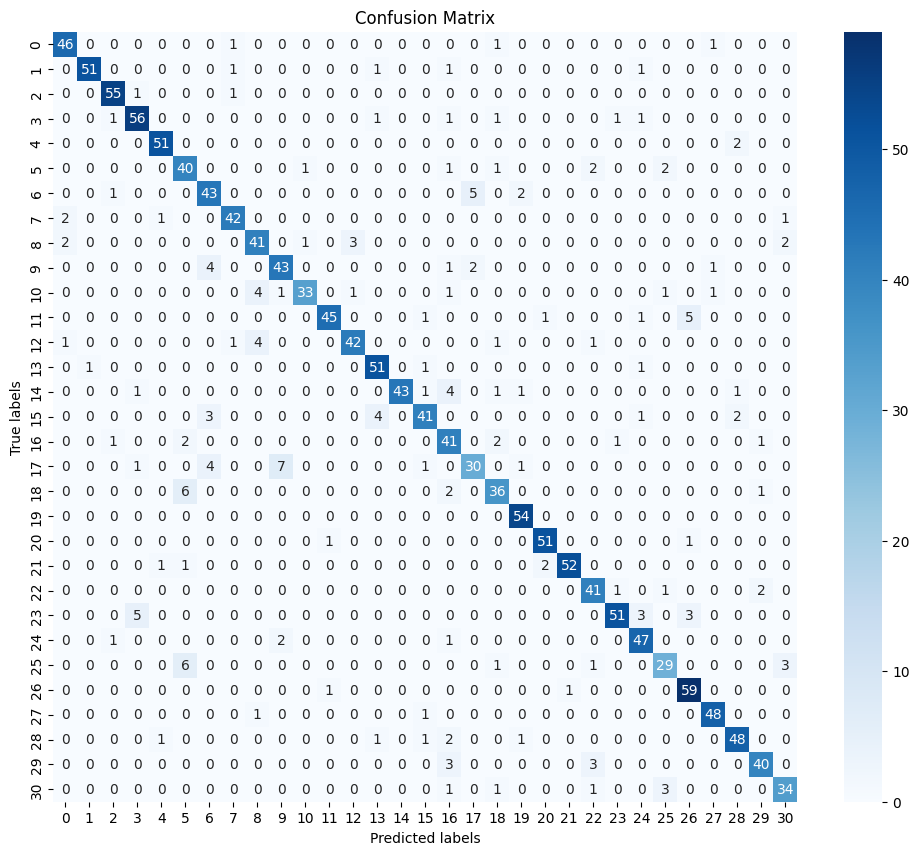

In [17]:
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [18]:
model.save('arabic_sign_lang.keras')